# Monte Carlo simulator
By: Magnus Kvåle Helliesen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from monte_carlo.monte_carlo import MonteCarlo

## Mathematical background

Suppose we have a matrix of data
$$
    \boldsymbol{X}=(\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1}),
$$
where
$$
    \boldsymbol{x}_i=\{x_{i, t}\}_{t=0}^{T-1}
$$
is a vector representing the timeseries for some $i$ (maybe a stock ticker or something).

The aim of this notebook is to use eigen decomposition to generate $N$ independent/orthogonal disturbances, normalize these using a GARCH-model (so there is no heteroskedasticity), and draw from the resulting (empirical) distributions, in order to perform a MonteCarlo-like simulation of the input data.

The idea is that
$$
    \frac{1}{T}(\boldsymbol{X}-\bar{\boldsymbol{X}})'(\boldsymbol{X}-\bar{\boldsymbol{X}})
    =\frac{1}{T}\boldsymbol{\varepsilon}'\boldsymbol{\varepsilon}
    =\boldsymbol{\Sigma}
    =\boldsymbol{Q}\boldsymbol{\Lambda}\boldsymbol{Q}^{-1},
$$
that is that the covariance matrix $\boldsymbol{\Sigma}$ can be decomposed into a product of it's eigenvectors $\boldsymbol{Q}$ and eigenvalues $\boldsymbol{\Lambda}$. If we calculate $\boldsymbol{Q}$ and $\boldsymbol{\Lambda}$, then we can construct
$$
    \boldsymbol{\eta}=\boldsymbol{\varepsilon}\boldsymbol{Q}\boldsymbol{\Lambda}^{-1/2},
$$
which has the property that
$$
    \frac{1}{T}\boldsymbol{\eta}'\boldsymbol{\eta}
    =\boldsymbol{\Lambda}^{-1/2}\boldsymbol{Q}^{-1}\frac{1}{T}\boldsymbol{\varepsilon}'\boldsymbol{\varepsilon}\boldsymbol{Q}\boldsymbol{\Lambda}^{-1/2}
    =\boldsymbol{\Lambda}^{-1/2}\boldsymbol{Q}^{-1}\boldsymbol{Q}\boldsymbol{\Lambda}\boldsymbol{Q}^{-1}\boldsymbol{Q}\boldsymbol{\Lambda}^{-1/2}
    =\boldsymbol{I}.
$$
In other words, $\boldsymbol{\eta}$ are orthogonal disturbances. Therefore, we can make $S$ simulations of $\boldsymbol{\eta}$, let's call it
$\hat{\boldsymbol{\eta}}$ and construct simulations of $\boldsymbol{X}$, let's call it $\hat{\boldsymbol{X}}$, using
$$
    \hat{\boldsymbol{X}}
    =\underbrace{\hat{\boldsymbol{\eta}}\boldsymbol{\Lambda}^{1/2}\boldsymbol{Q}^{-1}}_{\hat{\boldsymbol{\varepsilon}}}+\bar{\boldsymbol{X}}.
$$
What's neat (and also the point) is that
$$
    \frac{1}{S}\hat{\boldsymbol{\varepsilon}}'\hat{\boldsymbol{\varepsilon}}
    =\boldsymbol{Q}\boldsymbol{\Lambda}^{1/2}\frac{1}{S}\hat{\boldsymbol{\eta}}'\hat{\boldsymbol{\eta}}\boldsymbol{\Lambda}^{1/2}\boldsymbol{Q}^{-1}
    \simeq \boldsymbol{Q}\boldsymbol{\Lambda}\boldsymbol{Q}^{-1}
    =\boldsymbol{\Sigma},
$$
because $\frac{1}{S}\hat{\boldsymbol{\eta}}'\hat{\boldsymbol{\eta}}\simeq \boldsymbol{I}$. That is, the simulations preserve the covariance structure.

The whole shabang is done below (including removing heteroskedasticity from $\boldsymbol{\eta}$ using a GARCH-model). The implementation of the Monte Carlo stuff is put in [`monte_carlo.py`](monte_carlo/monte_carlo.py).

# Use MonteCarlo class

In [2]:
# Function that fetches data
def fetch_data(tickers: tuple):
    data = {}
    for ticker in tickers:
        data[ticker] = yf.Ticker(ticker).history(period='max')

    # Returning transformed data
    return (
        pd.concat(data)[['Close']]
        .reset_index()
        .rename(columns={'level_0': 'Ticker'})
        .pivot(index='Date', columns='Ticker', values='Close')
    )

tickers = ('NHY.OL', 'DNB.OL', 'YAR.OL', 'KOG.OL', 'TEL.OL', 'FRO.OL')
df = fetch_data(tickers).dropna()
df

Ticker,DNB.OL,FRO.OL,KOG.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-25 00:00:00+01:00,17.060760,668.643860,13.286466,10.964586,18.962238,22.093433
2004-03-26 00:00:00+01:00,17.216925,670.436218,13.286466,10.977164,19.238768,22.526640
2004-03-29 00:00:00+02:00,17.255959,702.703064,13.544456,10.914293,19.712828,21.985134
2004-03-30 00:00:00+02:00,17.177879,700.910583,13.221970,10.826274,18.646202,21.660227
2004-03-31 00:00:00+02:00,17.568285,699.117859,13.221970,10.863996,18.804214,21.573586
...,...,...,...,...,...,...
2023-11-13 00:00:00+01:00,203.199997,240.350006,463.200012,60.139999,116.500000,363.299988
2023-11-14 00:00:00+01:00,204.000000,233.399994,470.399994,62.220001,115.699997,370.700012
2023-11-15 00:00:00+01:00,205.100006,238.000000,474.200012,64.379997,112.400002,377.700012


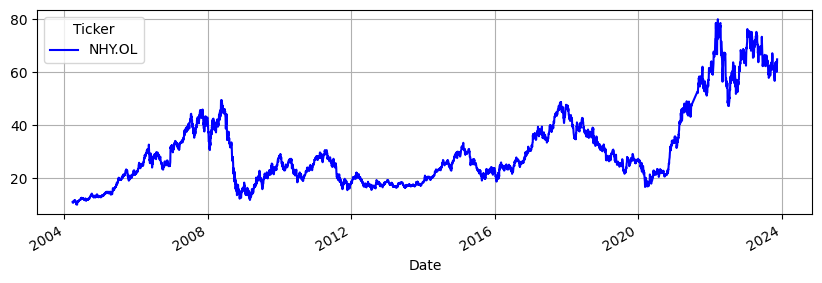

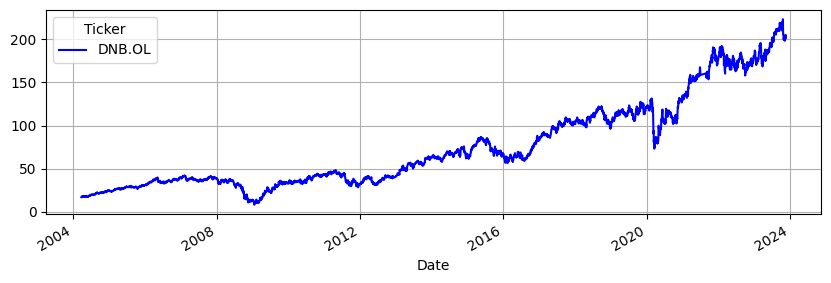

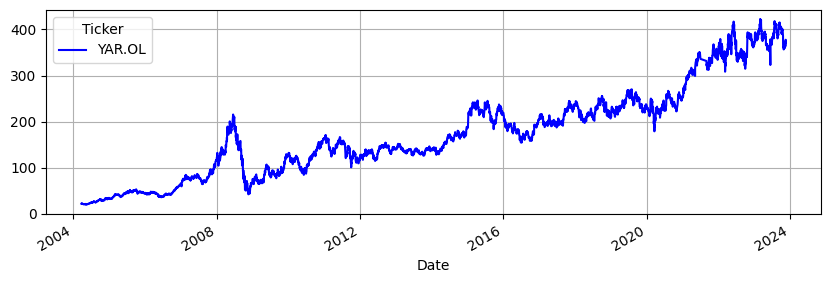

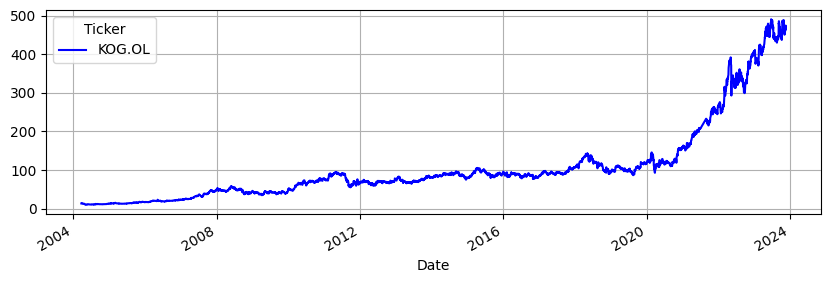

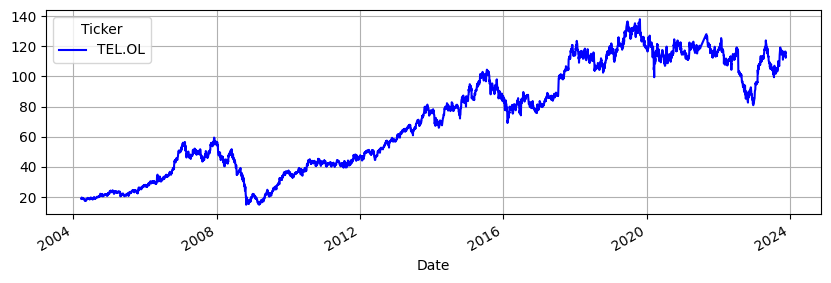

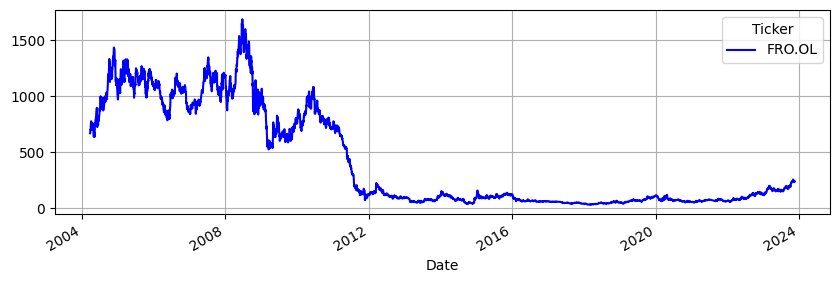

In [3]:
for ticker in tickers:
    df[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [4]:
# Calculating log-differences and removing first value
df_diff = np.log(df).diff().iloc[1:, :]
df_diff

Ticker,DNB.OL,FRO.OL,KOG.OL,NHY.OL,TEL.OL,YAR.OL
Date,,,,,,
2004-03-26 00:00:00+01:00,0.009112,0.002677,0.000000,0.001146,0.014478,0.019418
2004-03-29 00:00:00+02:00,0.002265,0.047006,0.019231,-0.005744,0.024342,-0.024332
2004-03-30 00:00:00+02:00,-0.004535,-0.002554,-0.024097,-0.008097,-0.055627,-0.014889
2004-03-31 00:00:00+02:00,0.022473,-0.002561,0.000000,0.003478,0.008439,-0.004008
2004-04-01 00:00:00+02:00,-0.011173,0.042667,-0.019705,-0.005804,-0.004210,0.004008
...,...,...,...,...,...,...
2023-11-13 00:00:00+01:00,0.013875,0.009826,0.006498,-0.006299,0.014264,-0.002749
2023-11-14 00:00:00+01:00,0.003929,-0.029343,0.015424,0.034001,-0.006891,0.020164
2023-11-15 00:00:00+01:00,0.005378,0.019517,0.008046,0.034126,-0.028937,0.018707


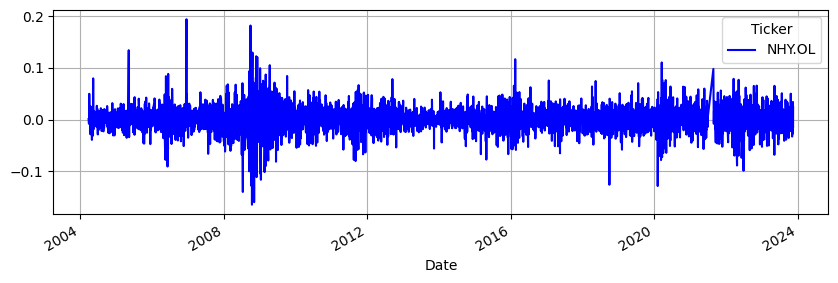

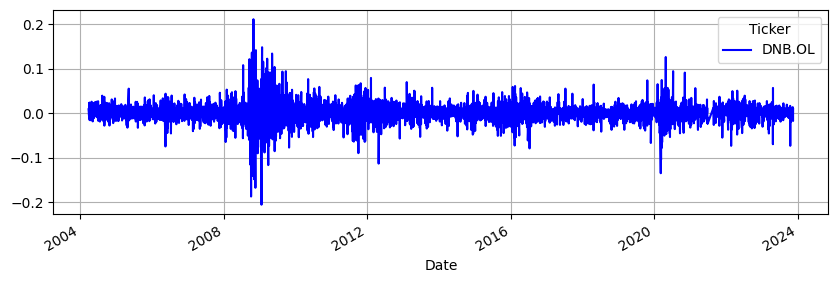

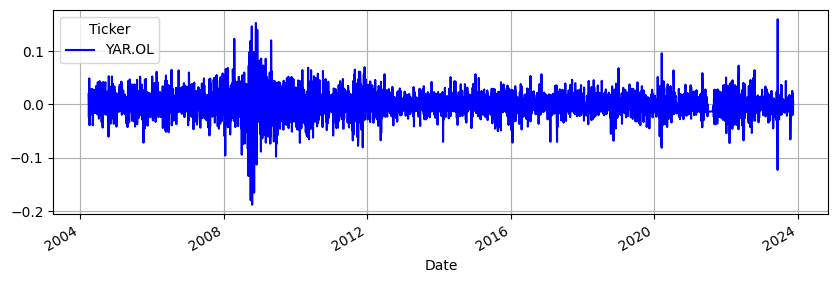

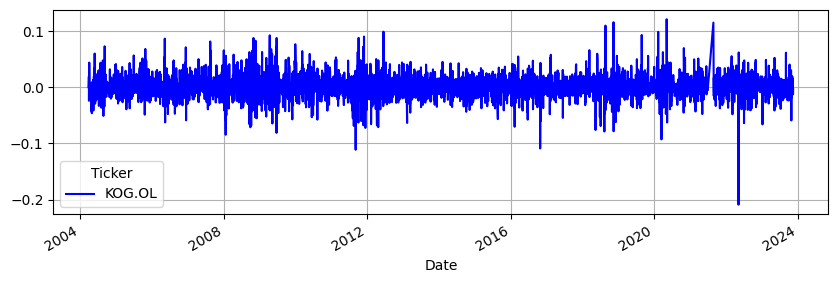

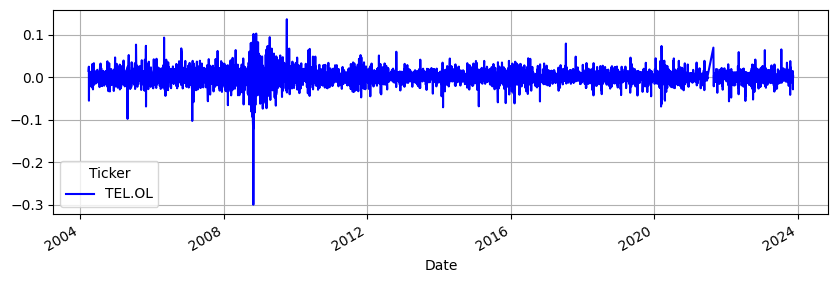

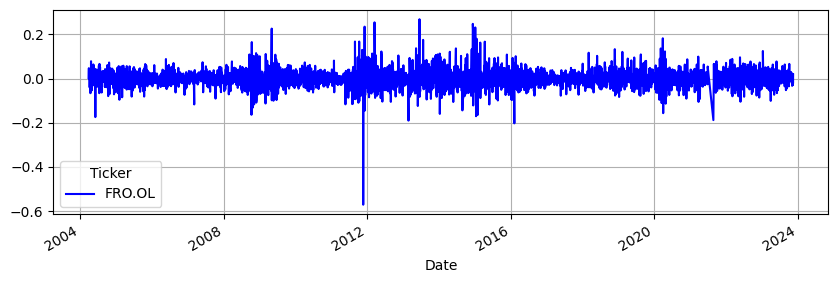

In [5]:
for ticker in tickers:
    df_diff[[ticker]].plot(color='b', figsize=(10, 3), grid=True)

In [6]:
df_diff.corr().style.background_gradient(cmap='Blues')

Ticker,DNB.OL,FRO.OL,KOG.OL,NHY.OL,TEL.OL,YAR.OL
Ticker,,,,,,
DNB.OL,1.000000,0.254121,0.259227,0.482635,0.387082,0.416598
FRO.OL,0.254121,1.000000,0.143901,0.316786,0.195920,0.277017
KOG.OL,0.259227,0.143901,1.000000,0.247915,0.206166,0.199280
NHY.OL,0.482635,0.316786,0.247915,1.000000,0.349601,0.485139
TEL.OL,0.387082,0.195920,0.206166,0.349601,1.000000,0.344185
YAR.OL,0.416598,0.277017,0.199280,0.485139,0.344185,1.000000


In [7]:
model = MonteCarlo(df_diff)
fit = model.fit()

# Okay, the disturbances are orthogonal. This we can work with
fit.orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,1.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000
1,-0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000
2,-0.000000,-0.000000,1.000000,-0.000000,-0.000000,0.000000
3,0.000000,-0.000000,-0.000000,1.000000,-0.000000,0.000000
4,0.000000,-0.000000,-0.000000,-0.000000,1.000000,0.000000
5,-0.000000,-0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
# The normalized ones are nearly orthogonal too
fit.norm_orthog_disturbances_df.cov().style.background_gradient(cmap='Blues')

,0,1,2,3,4,5
0,0.999902,-0.068020,0.021653,-0.000061,0.006779,0.048016
1,-0.068020,1.000139,0.011907,-0.004355,0.030836,0.065357
2,0.021653,0.011907,1.000837,-0.001721,-0.026902,-0.022747
3,-0.000061,-0.004355,-0.001721,1.000176,-0.034762,-0.032277
4,0.006779,0.030836,-0.026902,-0.034762,1.000444,-0.051075
5,0.048016,0.065357,-0.022747,-0.032277,-0.051075,1.000551


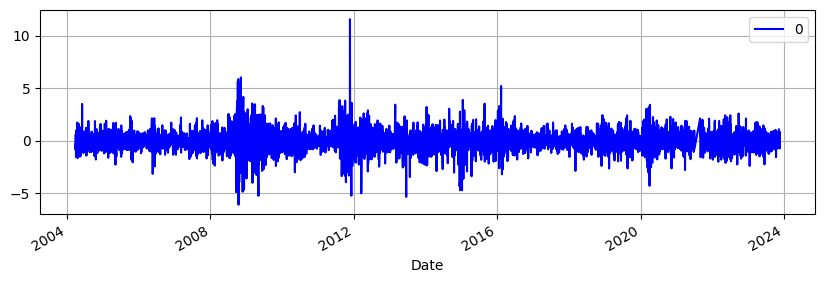

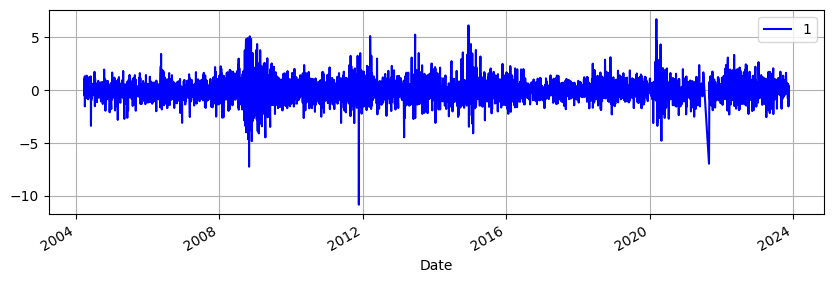

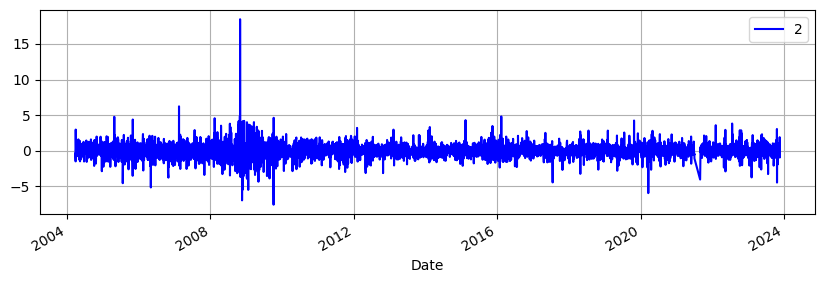

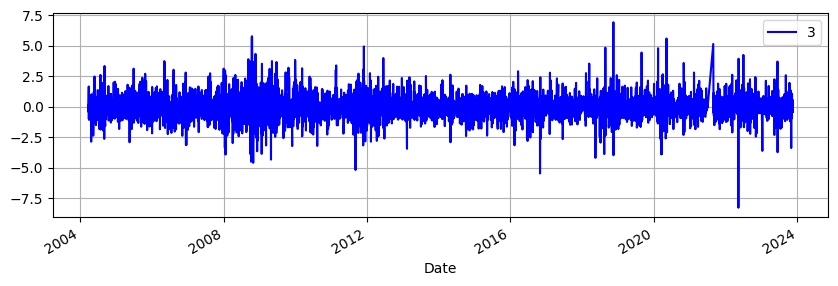

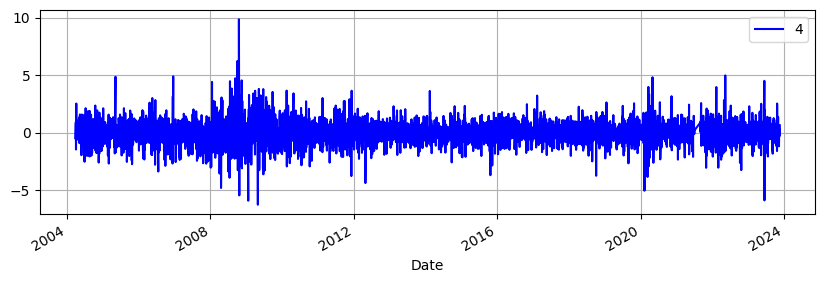

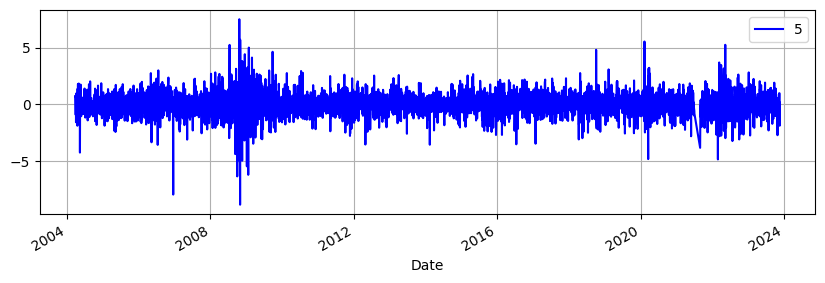

In [9]:
# Orthogonal disturbances
for col in fit.orthog_disturbances_df.columns:
    fit.orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

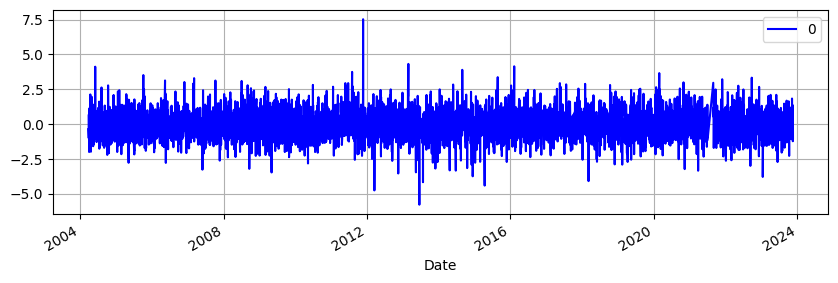

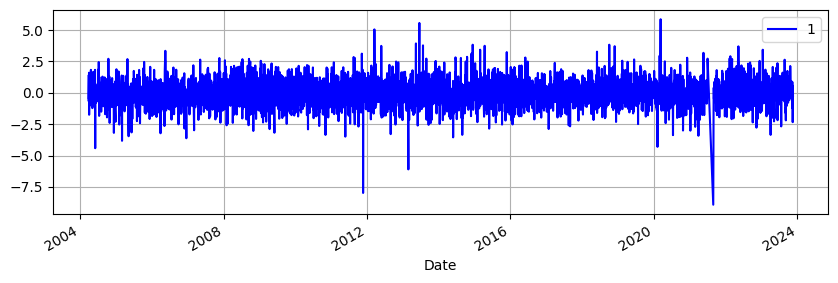

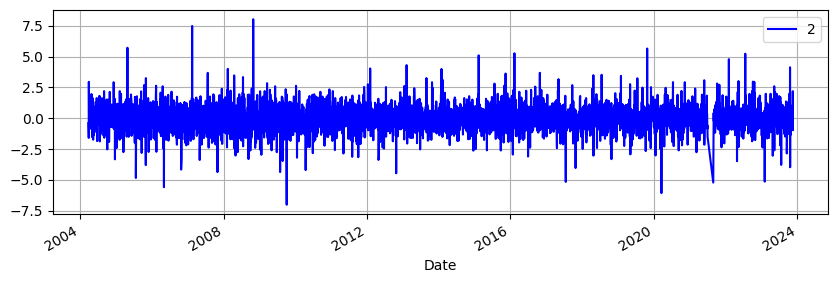

In [10]:
# Orthognal disturbances where heteroskedasticity is removed using GARCH model fits
for col in fit.orthog_disturbances_df.columns:
    fit.norm_orthog_disturbances_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

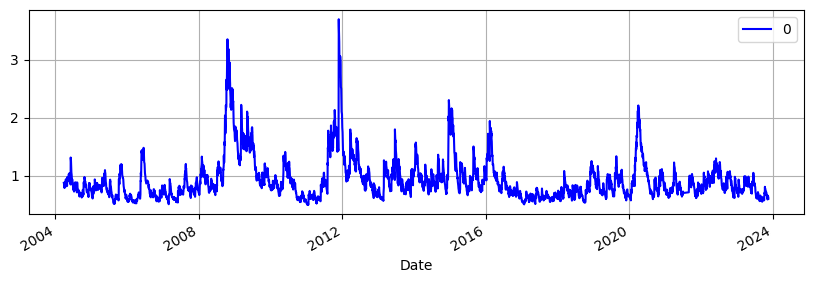

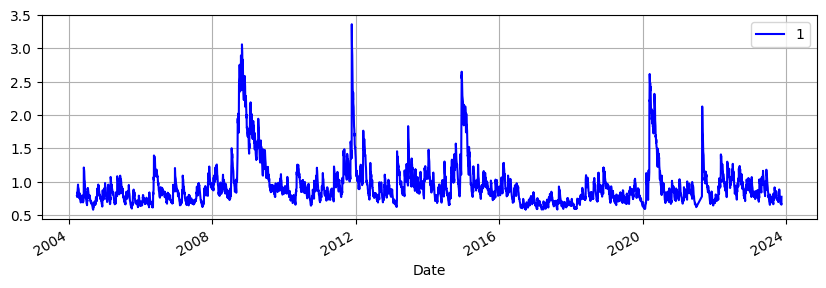

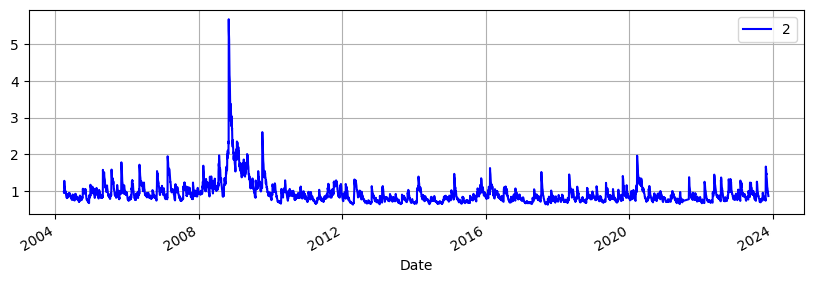

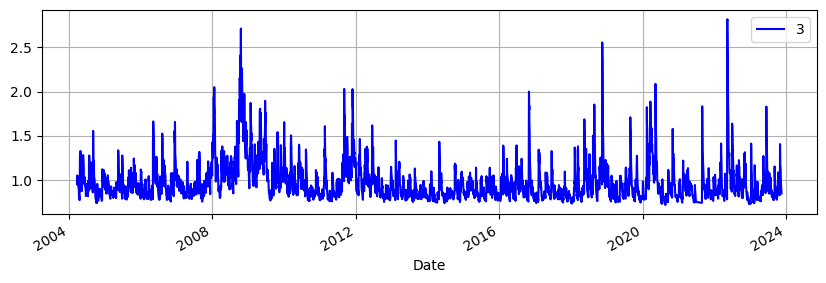

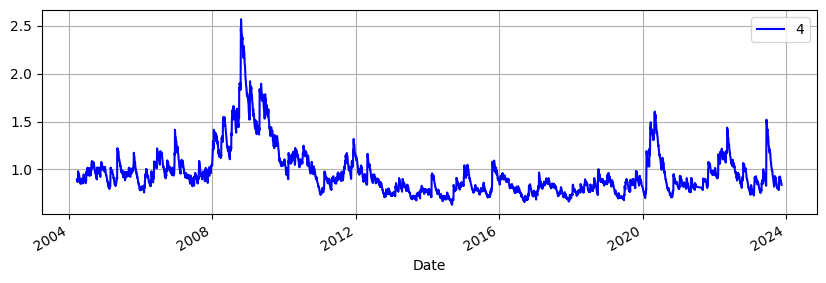

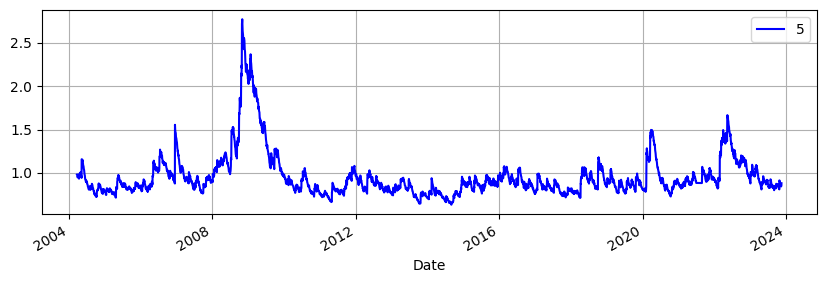

In [ ]:
# Look at GARCH-estimated volatility
for col in fit.conditional_volatility_df.columns:
    fit.conditional_volatility_df[[col]].plot(color='b', figsize=(10, 3), grid=True)

In [ ]:
n_periods = 365
n_simulations = 500

# Store forecast in dict
forecast = fit.simulate(n_periods, n_simulations)

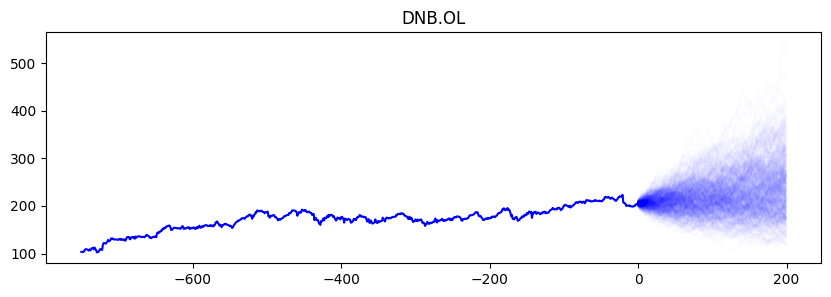

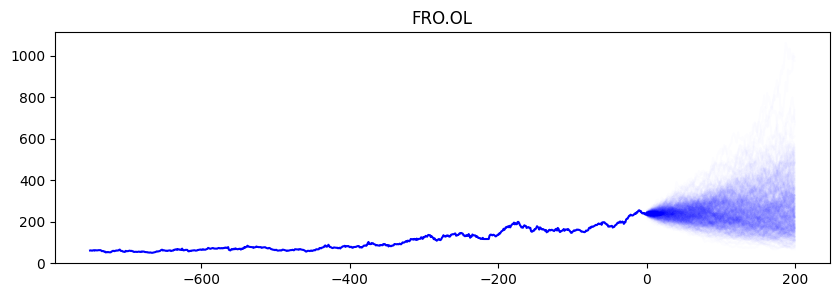

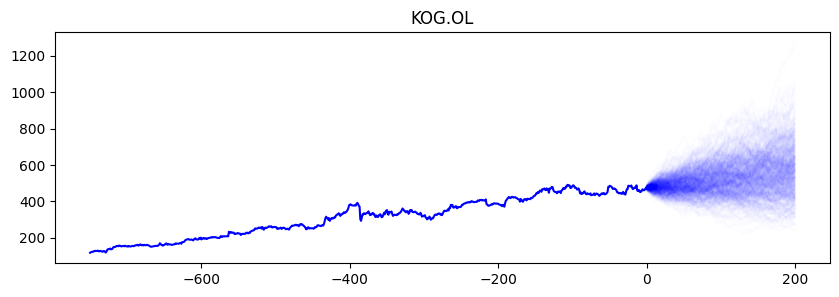

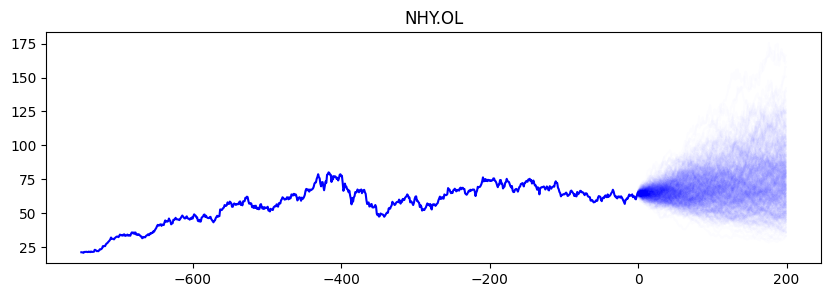

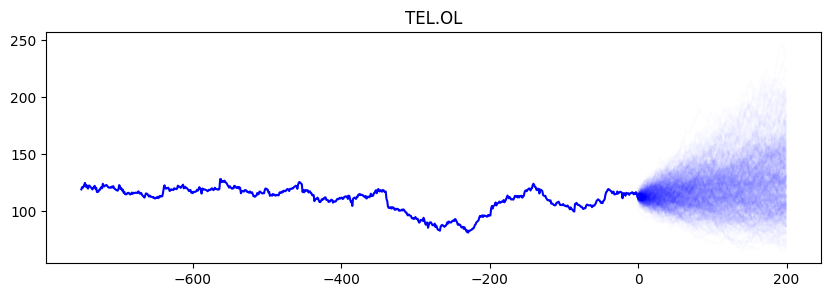

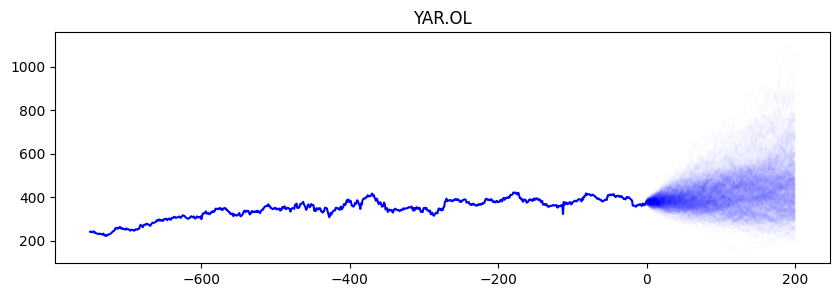

In [ ]:
# Make a new df with index that runs to -1 to allow for plot of simulation from 0
df_range_index = df
df_range_index.index = range(-df_range_index.shape[0], 0)

# Look at some forecast around 0
for col in df.columns:
    plt.figure()
    for i in range(n_simulations):
        (df[col].iloc[-1]*np.exp(forecast.get(i)[col].cumsum())).plot(
            color = 'b', alpha=5/n_simulations, figsize=(10, 3), grid=True, title=col
            )
    df_range_index.loc[-1000:, col].plot(color = 'b')
    plt.show()